In [11]:
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [12]:
db = SynphysDatabase.load_current('small')

In [13]:
inhib_subclasses = {
    'pv': CellClass(cre_type='pvalb', name='pv'),
    'sst': CellClass(cre_type='sst', name='sst'),
    'vip': CellClass(cre_type='vip', name='vip'),
}

In [14]:
# query once for each postsynaptic type, building up a Pandas dataframe
pairs = None
for name, subclass in inhib_subclasses.items():
    pair_query = db.pair_query(
        experiment_type='mouse',
        pre_class=subclass,
        post_class=subclass,
        electrical=True,
    )
    # here we join the GapJunction table so that we can append the junctional_conductance column
    pair_query = pair_query.outerjoin(db.GapJunction, db.GapJunction.pair_id==db.Pair.id)
    pair_query = pair_query.add_column(db.GapJunction.junctional_conductance)

    df = pair_query.dataframe()
    df['pair_class'] = '%s→%s' % (subclass, subclass)
    if pairs is None:
        pairs = df
    else:
        pairs = pairs.append(df)
pairs['gap_junction.junctional_conductance'] *= 1e9 # we typcially think of conductance on the scale of nano-Siemens (nS)
pairs.head()

,pair.id,pair.experiment_id,pair.pre_cell_id,pair.post_cell_id,pair.has_synapse,pair.has_polysynapse,pair.has_electrical,pair.crosstalk_artifact,pair.n_ex_test_spikes,pair.n_in_test_spikes,pair.distance,pair.lateral_distance,pair.vertical_distance,pair.reciprocal_id,pair.meta,gap_junction.junctional_conductance,pair_class
0,21877,479,3367,3372,True,False,True,NaN,462,410,0.000051,0.000034,0.000005,21928,None,NaN,pv→pv
1,22812,500,3510,3511,False,False,True,NaN,180,0,0.000101,0.000028,0.000098,22834,None,NaN,pv→pv
2,22834,500,3511,3510,False,False,True,NaN,216,0,0.000101,0.000028,0.000098,22812,None,NaN,pv→pv
3,24695,546,3814,3810,True,False,True,NaN,180,180,0.000064,NaN,NaN,24670,None,NaN,pv→pv
4,29756,700,4705,4711,True,False,True,NaN,856,856,0.000074,0.000066,0.000003,29793,None,NaN,pv→pv


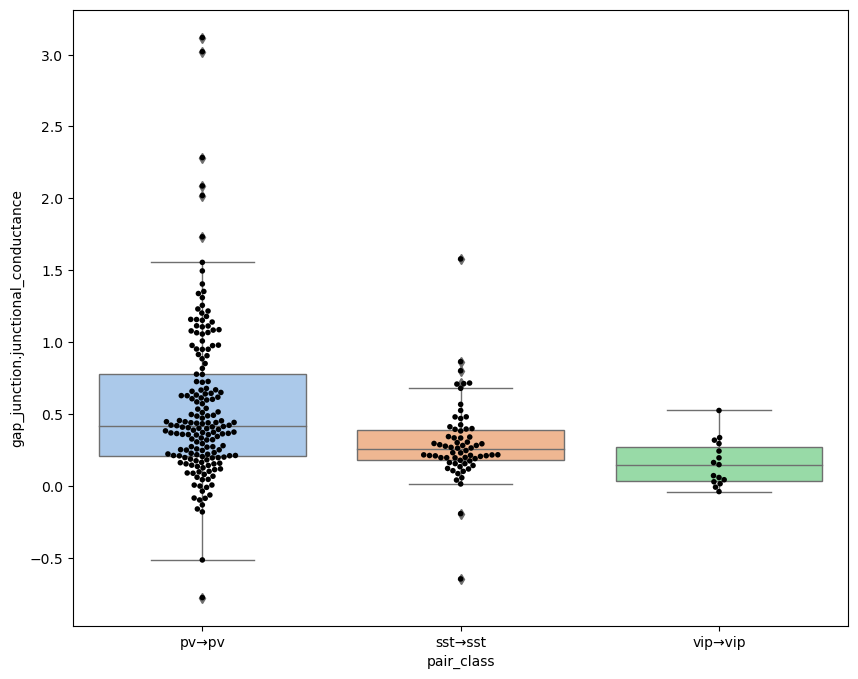

In [16]:
import seaborn as sns

fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.swarmplot(data=pairs, x='pair_class', y='gap_junction.junctional_conductance', size=4, color=(0, 0, 0, 0.5), label='Experiment Data',ax=axes)
sns.boxplot(data=pairs, x='pair_class', y='gap_junction.junctional_conductance',palette='pastel', width=0.8, linewidth=1,ax=axes)
plt.show()